In [187]:
import tensorflow as tf
from d2l import tensorflow as d2l
d2l.use_svg_display()
import pdb
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


In [188]:
class MNIST(d2l.DataModule): #@save
    """The MNIST dataset."""
    def __init__(self, batch_size=64):
        super().__init__()
        self.save_hyperparameters()
        self.train, self.val = tf.keras.datasets.mnist.load_data()


In [189]:
data = MNIST()
print(len(data.train[0]), len(data.val[0]))
print(data.train[0].shape)

60000 10000
(60000, 28, 28)


In [190]:
@d2l.add_to_class(MNIST) #@save
def get_dataloader(self, train):
    data = self.train if train else self.val
    process = lambda X, y: (tf.expand_dims(X, axis=3) / 255, tf.cast(y, dtype='int32'))
    resize_fn = lambda X, y: (tf.image.resize_with_pad(X, *self.resize), y)
    shuffle_buf = len(data[0]) if train else 1
    return tf.data.Dataset.from_tensor_slices(process(*data)).batch(self.batch_size).shuffle(shuffle_buf)

In [191]:
X, y = next(iter(data.train_dataloader()))
print(X.shape, X.dtype, y.shape, y.dtype)

(64, 28, 28, 1) <dtype: 'float32'> (64,) <dtype: 'int32'>


In [194]:
class MLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr, loss_fn=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.SGD()):
        super().__init__()
        self.save_hyperparameters()
        self.net = tf.keras.models.Sequential([
            tf.keras.layers.Flatten(input_shape=(28, 28)),
            tf.keras.layers.Dense(num_hiddens, activation='sigmoid'),
            tf.keras.layers.Dense(num_outputs, activation='sigmoid')])

0.9054

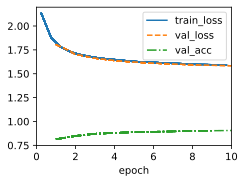

In [195]:
model = MLP(num_outputs=10, num_hiddens=128, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)
test_acc = d2l.evaluate_accuracy(model, data.val_dataloader())
test_acc

In [201]:
class MLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr, loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=tf.keras.optimizers.SGD()):
        super().__init__()
        self.save_hyperparameters()
        self.net = tf.keras.models.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(num_hiddens, activation='sigmoid'),
            tf.keras.layers.Dense(num_outputs, activation='softmax')])


0.9012

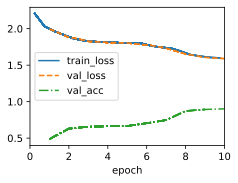

In [202]:
model = MLP(num_outputs=10, num_hiddens=128, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)
test_acc = d2l.evaluate_accuracy(model, data.val_dataloader())
test_acc

In [203]:
class MLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr, loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam()):
        super().__init__()
        self.save_hyperparameters()
        self.net = tf.keras.models.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(num_hiddens, activation='sigmoid'),
            tf.keras.layers.Dense(num_outputs, activation='softmax')])

0.8358

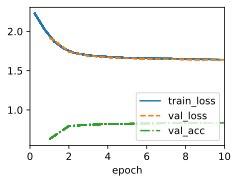

In [204]:
model = MLP(num_outputs=10, num_hiddens=128, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)
test_acc = d2l.evaluate_accuracy(model, data.val_dataloader())
test_acc

In [212]:
class MLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr, loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam()):
        super().__init__()
        self.save_hyperparameters()
        self.net = tf.keras.models.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(num_hiddens, activation='relu'),
            tf.keras.layers.Dense(num_outputs, activation='softmax')])

0.8523

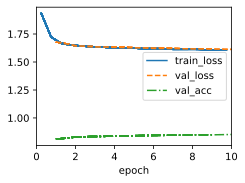

In [211]:
model = MLP(num_outputs=10, num_hiddens=128, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)
test_acc = d2l.evaluate_accuracy(model, data.val_dataloader())
test_acc

0.947

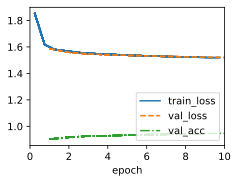

In [207]:
model = MLP(num_outputs=10, num_hiddens=256, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)
test_acc = d2l.evaluate_accuracy(model, data.val_dataloader())
test_acc

In [208]:
class MLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr, loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam()):
        super().__init__()
        self.save_hyperparameters()
        self.net = tf.keras.models.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(num_hiddens, activation='relu'),
            tf.keras.layers.Dense(num_hiddens, activation='relu'),
            tf.keras.layers.Dense(num_outputs, activation='softmax')])

0.9642

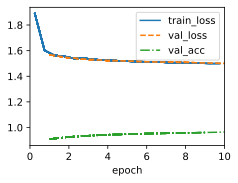

In [209]:
model = MLP(num_outputs=10, num_hiddens=256, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)
test_acc = d2l.evaluate_accuracy(model, data.val_dataloader())
test_acc

In [ ]:
X,y=next(iter(data.val_dataloader()))
preds=tf.argmax(model(X),axis=1)
preds.shape

TensorShape([64])

In [ ]:
wrong=tf.cast(preds,y.dtype)!=y
X,y,preds=X[wrong],y[wrong],preds[wrong]
labels=[a+'\n'+b for a,b in zip(data.text_labels(y),data.text_labels(preds))]
data.visualize([X,y],labels=labels)

AttributeError: 'MNIST' object has no attribute 'text_labels'